# Self-supervised learning with measurement splitting

We demonstrate self-supervised learning with measurement splitting, to train a denoiser network on the MNIST dataset. The physics here is noiseless undersampled MRI.

In [1]:
import deepinv as dinv
from torch.utils.data import DataLoader
import torch
from torchvision import transforms, datasets
from deepinv.models.utils import get_weights_url
from deepinv.physics.generator import GaussianMaskGenerator
from numpy.random import default_rng

c:\Users\s2558406\Documents\Repos\deepinv\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(0)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

### Define loss

In [3]:
loss = dinv.loss.SplittingLoss(split_ratio=0.6, eval_split_input=True, eval_n_samples=5)

### Prepare data

In [4]:
transform = transforms.Compose([transforms.ToTensor(), lambda x: torch.cat([x] * 2)])

train_dataset = datasets.MNIST(
    root=".", train=True, transform=transform, download=True
)
test_dataset = datasets.MNIST(
    root=".", train=False, transform=transform, download=True
)

In [5]:
physics = dinv.physics.MRI(
    mask=GaussianMaskGenerator((2, 28, 28), acceleration=4, rng=default_rng(0)).step()["mask"],
    device=device
)

deepinv_datasets_path = dinv.datasets.generate_dataset(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    physics=physics,
    device=device,
    save_dir="MNIST",
    train_datapoints=1000,#100
    test_datapoints=10,
)

train_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=True)
test_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=False)

train_dataloader = DataLoader(train_dataset, shuffle=True)
test_dataloader = DataLoader(test_dataset,  shuffle=False)

Dataset has been saved in MNIST


In [6]:
x, y = next(iter(test_dataloader))
print(x.max(), y.max())

tensor(1.) tensor(2.5846)


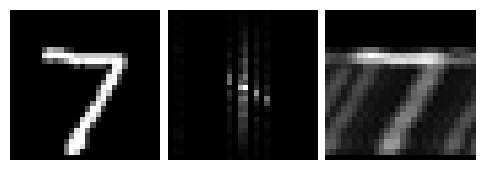

In [7]:
dinv.utils.plot([x, y, physics.A_adjoint(y)])

### Define model

We use a simple U-Net architecture with 2 scales as the denoiser network. 

In [8]:
model = dinv.models.ArtifactRemoval(
    dinv.models.UNet(in_channels=2, out_channels=2, scales=2).to(device)
)
model = loss.adapt_model(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

# Load pretrained model
# file_name = "demo_measplit_mnist_tomography.pth"
# url = get_weights_url(model_name="measplit", file_name=file_name)
# ckpt = torch.hub.load_state_dict_from_url(
#     url, map_location=lambda storage, loc: storage, file_name=file_name
# )

# model.load_state_dict(ckpt["state_dict"])
# optimizer.load_state_dict(ckpt["optimizer"])

## Train and test network

In [9]:
trainer = dinv.Trainer(
    model=model,
    physics=physics,
    epochs=20,#3
    losses=loss,
    optimizer=optimizer,
    device=device,
    train_dataloader=train_dataloader,
    plot_images=False,
    save_path=None,
    verbose=True,
    show_progress_bar=False,
    wandb_vis=False,
    rescale_mode="min_max",
)

model = trainer.train()

The model has 445378 trainable parameters
Train epoch 0: TotalLoss=0.052, PSNR=11.962
Train epoch 1: TotalLoss=0.029, PSNR=12.593
Train epoch 2: TotalLoss=0.024, PSNR=12.697
Train epoch 3: TotalLoss=0.02, PSNR=12.912
Train epoch 4: TotalLoss=0.019, PSNR=13.057
Train epoch 5: TotalLoss=0.018, PSNR=13.029
Train epoch 6: TotalLoss=0.017, PSNR=13.17
Train epoch 7: TotalLoss=0.015, PSNR=13.207
Train epoch 8: TotalLoss=0.014, PSNR=13.245
Train epoch 9: TotalLoss=0.015, PSNR=13.316
Train epoch 10: TotalLoss=0.013, PSNR=13.334
Train epoch 11: TotalLoss=0.013, PSNR=13.371
Train epoch 12: TotalLoss=0.012, PSNR=13.448
Train epoch 13: TotalLoss=0.013, PSNR=13.38
Train epoch 14: TotalLoss=0.012, PSNR=13.527
Train epoch 15: TotalLoss=0.011, PSNR=13.559
Train epoch 16: TotalLoss=0.012, PSNR=13.477
Train epoch 17: TotalLoss=0.011, PSNR=13.589
Train epoch 18: TotalLoss=0.01, PSNR=13.65
Train epoch 19: TotalLoss=0.01, PSNR=13.709


In [10]:
torch.save({"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}, "demo_measplit_mnist_amri.pth")

Test

The model has 445378 trainable parameters
Eval epoch 0: PSNR=16.108, PSNR no learning=13.999


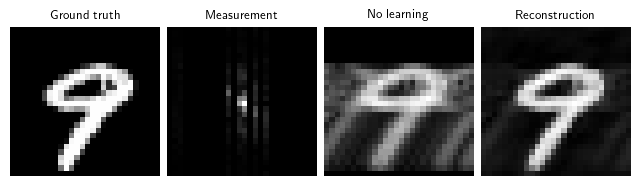

Test results:
PSNR no learning: 13.999 +- 1.112
PSNR: 16.108 +- 2.293


{'PSNR no learning': 13.99926462173462,
 'PSNR no learning_std': 1.1116921880018424,
 'PSNR': 16.108364486694335,
 'PSNR_std': 2.293143492454918}

In [11]:
trainer.plot_images = True
trainer.test(test_dataloader)

Demonstrate the effect of not averaging over multiple realisations of the splitting mask at evaluation time, by setting `eval_n_samples=1`. We have a worse performance:

The model has 445378 trainable parameters
Eval epoch 0: PSNR=14.354, PSNR no learning=13.999


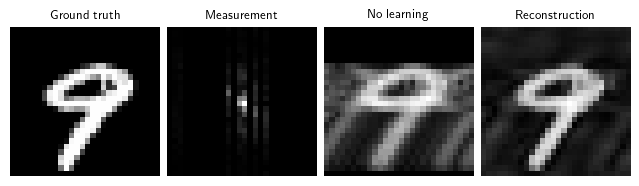

Test results:
PSNR no learning: 13.999 +- 1.112
PSNR: 14.354 +- 2.984


{'PSNR no learning': 13.99926462173462,
 'PSNR no learning_std': 1.1116921880018424,
 'PSNR': 14.353833389282226,
 'PSNR_std': 2.9838297099206}

In [12]:
model.eval_n_samples = 1
trainer.test(test_dataloader)

Furthermore, we can disable measurement splitting at evaluation altogether by setting `eval_split_input` to False (this is done in [SSDU](https://pubmed.ncbi.nlm.nih.gov/32614100/)). This generally is worse than MC averaging:

The model has 445378 trainable parameters
Eval epoch 0: PSNR=11.126, PSNR no learning=13.999


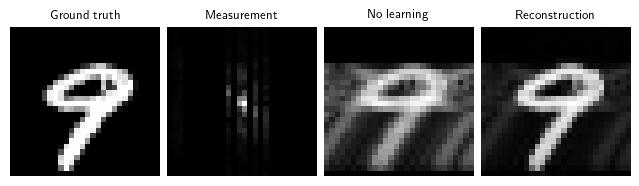

Test results:
PSNR no learning: 13.999 +- 1.112
PSNR: 11.126 +- 2.130


{'PSNR no learning': 13.99926462173462,
 'PSNR no learning_std': 1.1116921880018424,
 'PSNR': 11.126238059997558,
 'PSNR_std': 2.12953882578676}

In [13]:
model.eval_split_input = False
trainer.test(test_dataloader)